In [36]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [37]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,sqft_lot15_log,age,bedrooms,...,reno_1.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,268950.0,12.502281,8100,8.999619,1000,6.907755,8100,8.999619,72,3,...,0,0,0,0,0,1,0,0,0,0
20963,399900.0,12.898970,1005,6.912743,1440,7.272398,1188,7.080026,4,2,...,0,0,0,0,0,0,0,1,0,0
7614,339000.0,12.733755,4128,8.325548,1510,7.319865,4538,8.420242,73,3,...,0,1,0,0,0,0,0,0,0,0
3257,380000.0,12.847927,7372,8.905444,1930,7.565275,5150,8.546752,76,2,...,0,1,0,0,0,0,0,0,0,0
16723,365000.0,12.807653,4168,8.335192,1190,7.081709,4168,8.335192,88,5,...,0,1,0,0,0,0,0,0,0,0


In [38]:
clean.columns

Index(['price', 'price_log', 'sqft_lot', 'sqft_lot_log', 'sqft_living15',
       'sqft_living15_log', 'sqft_lot15', 'sqft_lot15_log', 'age', 'bedrooms',
       'bathrooms', 'grade', 'floors_1.5', 'floors_2.0', 'floors_2.5',
       'floors_3.0', 'floors_3.5', 'water_1.0', 'cond_2.0', 'cond_3.0',
       'cond_4.0', 'cond_5.0', 'base_1.0', 'reno_1.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

# FITTING AN INITIAL MODEL: 
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

We checked for linearity in the first part of the project. Now we are checking out the next two assumptions — normality and homoscedasticity. This requires us to first create a regression model because they refer to a model’s residuals rather than its features. 

This part of the project includes:

1. Fitting an initial regression model, and then conducting statistical analyses of the results. We'll take a look at the p-values of the various features and perform some feature selection. We'll test for regression assumptions including normality, heteroscedasticity, and independence. 
2. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.

## Perform Stepwise Selection

In [39]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

With the linear regression, you would interpret log transformed variables as a percentage change. Here’s a quick breakdown: (http://data-slinky.com/2016/09/06/log_trans.html)

* If your response variable, y, is log-transformed and assuming you have one predictor, a unit increase in the predictor x is associated with the x’s coefficient, call it b1, (b1*100) percentage increase in y.
* If your predictor is log-transformed(e.g., log(x)), then one unit increase of x means a (b1/100) percent increase in y.
* If both the response and the predictor is log-transformed then a one percent increase in x means a b1 percent increase in y.

In [40]:
#including all log-transformed features
preprocessed_2 = clean[['price_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log', 'age', 
                        'bedrooms', 'bathrooms', 'grade', 
                        'floors_1.5', 'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 
                        'water_1.0', 'base_1.0', 'reno_1.0',
                        'cond_2.0', 'cond_3.0', 'cond_4.0', 'cond_5.0', 
                        'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [41]:
#apply function
X = preprocessed_2.drop(['price_log'], axis=1)
y = preprocessed_2['price_log']

selected_features = stepwise_selection(X, y, verbose = True)
print('Resulting Selected Features:')
print(selected_features)

Add  grade                          with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  age                            with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  zip_G                          with p-value 1.06841e-296
Add  water_1.0                      with p-value 7.97412e-208
Add  zip_I                          with p-value 7.75408e-131
Add  cond_3.0                       with p-value 7.1429e-37
Add  sqft_lot_log                   with p-value 1.82067e-29
Add  cond_2.0                       with p-value 1.1104e-22
Add  zip_E                          with p-value 1.29234e-23
Add  floors_1.5                     with p-value 4.82998e-16
Add  base_1.0                       with p-value 1.50747e-18
Add  reno_1.0             

Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

**Features that satified p-value requirement:** 'grade', 'water_1.0', 'age', 'bathrooms', 'zip_C', 'zip_A', 'sqft_living15', 'zip_B', 'zip_G', 'zip_F', 'floors_2.5', 'zip_I', 'sqft_lot', 'cond_3.0', 'zip_E', 'reno_1.0', 'cond_5.0', 'floors_2.0'

The null hypothesis for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject the null hypothesis. All of the p-values indicate that all of the current features are substantially influential.

In [42]:
#check out how many features satisfy p < 0.05
len(selected_features)

27

## Build Model in Statsmodels

In [43]:
#build initial model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model = sm.OLS(y,X_intercept).fit() 

#get summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     3044.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:01:01   Log-Likelihood:                -18.524
No. Observations:               21420   AIC:                             91.05
Df Residuals:                   21393   BIC:                             306.3
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.0255      0.063    111.989      0.000       6.902       7.148
grade                 0.1868      0.002     79.254      0.000       0.182       0.191
zip_F                 0.4436      0.009     50.330      0.000       0.426       0.461
zip_A                 1.0471      0.007    140.104      0.000       1.032       1.062
zip_C                 1.0256      0.009    115.299      0.000       1.008       1.043
zip_B                 0.9797      0.009    114.402      0.000       0.963       0.996
age                   0.0030   9.76e-05     31.115      0.000       0.003       0.003
bathrooms             0.1131      0.004     30.293      0.000       0.106       0.120
sqft_living15_log     0.3578      0.008     44.268      0.000       0.342       0.374
zip_G                 0.9038      0.009     97.096      0.000       0.886       0.922
water_1.0             0.6391      0.021     31.176      0.000       0.599       0.679
zip_I                 0.8522      0.012     72.398      0.000       0.829       0.875
cond_3.0              0.2775      0.046      6.022      0.000       0.187       0.368
sqft_lot_log          0.0648      0.005     13.567      0.000       0.055       0.074
cond_2.0              0.1362      0.050      2.742      0.006       0.039       0.234
zip_E                 0.6451      0.009     71.489      0.000       0.627       0.663
floors_1.5            0.0700      0.007     10.652      0.000       0.057       0.083
base_1.0              0.0537      0.004     13.093      0.000       0.046       0.062
reno_1.0              0.0831      0.010      8.613      0.000       0.064       0.102
floors_2.0            0.0592      0.005     11.200      0.000       0.049       0.070
floors_3.0            0.1128      0.012      9.254      0.000       0.089       0.137
cond_5.0              0.3791      0.046      8.179      0.000       0.288       0.470
floors_2.5            0.1314      0.020      6.646      0.000       0.093       0.170
cond_4.0              0.3282      0.046      7.123      0.000       0.238       0.419
sqft_lot15_log       -0.0361      0.005     -6.871      0.000      -0.046      -0.026
zip_H                 0.5822      0.009     62.158      0.000       0.564       0.601
zip_D                 0.5462      0.009     61.660      0.000       0.529       0.564
bedrooms              0.0089      0.002      3.879      0.000       0.004       0.013
==============================================================================
Omnibus:                      586.653   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1427.999
Skew:                           0.080   Prob(JB):                    8.20e-311
Kurtosis:                       4.255   Cond. No.                     2.88e+15
======================

* We have a JB value = ~3710227, which is very high and not in favor of normality. 
* p-value of 0 which rejects the null hypothesis for normality. 
* Additionally, the kurtosis is above 66, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. 
* The skewness value of 4.494 shows that underlying data is highly skewed. 

## Build Model with Feature Ranking with Recursive Feature Elimination

Stepwise Selection selects features based on p-value. RFE ranks the variable on the basis on linear regression fit.
By combining them, we select for the 10 most important features.

RFE is popular because it is easy to configure and use and because it is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [44]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 18 to be consistent with previous stepwise feature selection
selector = RFE(linreg, n_features_to_select = 18) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([False,  True, False, False, False,  True,  True,  True, False,
        True, False, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False])

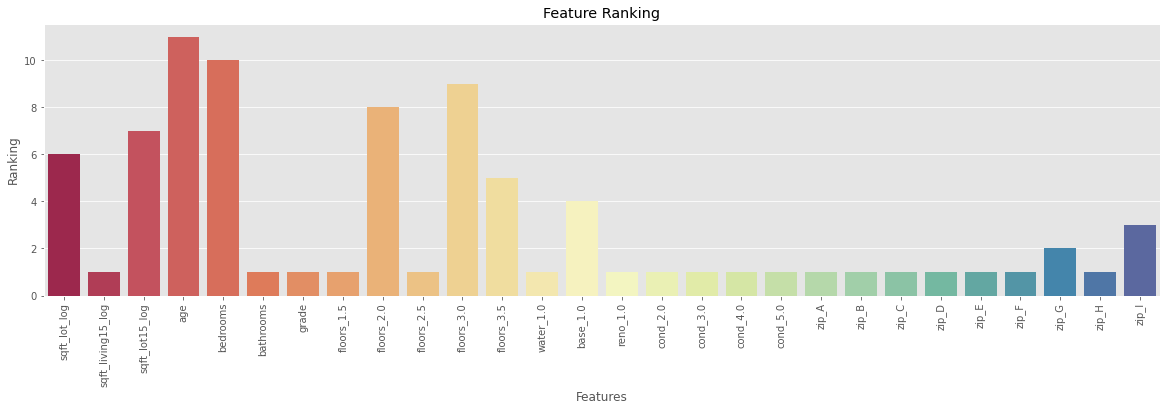

<Figure size 432x288 with 0 Axes>

In [45]:
#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X.columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/recursive_features_elimination')

**Stepwise Selection:** 'grade', 'water_1.0', 'age', 'bathrooms', 'zip_C', 'zip_A', 'sqft_living15', 'zip_B', 'zip_G', 'zip_F', 'floors_2.5', 'zip_I', 'sqft_lot', 'cond_3.0', 'zip_E', 'reno_1.0', 'cond_5.0', 'floors_2.0'

**RFE:** 

In [46]:
#fit the linear regression model again using the selected columns
selected_features = X.columns[selector.support_ ]
linreg.fit(X[selected_features], y)

LinearRegression()

In [47]:
#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

array([12.0984922 , 13.18171655, 12.97340563, ..., 12.62525775,
       13.03887152, 12.54244509])

r_square is used as "goodness of fit" which measure of the fitted line. It can take values between 0 and 1.
* r2 ~ 0 = poor fit
* r2 ~ 1 = good fit

In [48]:
#compute r-squared and contrast them with the r-squared (0.693) and adjusted r-squared (0.693) in our statsmodels output using stepwise selection
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_features].shape[1]-1)

print('r_squared:', r_squared)
print('adjusted_r_squared:', adjusted_r_squared)

r_squared: 0.769628986205753
adjusted_r_squared: 0.7694352252484008


Our r_squared and adjusted_r_squared are very very similar in both cases: 63% of the dataset's variation from the mean can be explained by our model.

In [49]:
#get intercept
linreg.intercept_

7.95494020671448

In [50]:
#get coefficients and sort them
coefficients = dict(zip(X,list(linreg.coef_)))
dict(sorted(coefficients.items(), key=lambda item: item[1]))

{'cond_3.0': -0.44551095902852406,
 'reno_1.0': -0.3296250593269596,
 'cond_4.0': -0.3250979787134018,
 'cond_2.0': -0.2002573166750982,
 'water_1.0': 0.09563611537515462,
 'sqft_living15_log': 0.10032291593254408,
 'age': 0.12302426611277256,
 'floors_1.5': 0.12441966115494792,
 'bedrooms': 0.13354279011489642,
 'base_1.0': 0.14549260725656069,
 'sqft_lot15_log': 0.17559818804960944,
 'grade': 0.18576692853078822,
 'floors_2.0': 0.19854460191221812,
 'floors_3.5': 0.2187645649666701,
 'floors_2.5': 0.30037691052070536,
 'floors_3.0': 0.3744971720238925,
 'sqft_lot_log': 0.4330426511872052,
 'bathrooms': 0.678467953482609}

**Features that add values:**
* 'grade'
* 'sqft_living15'
* 'base_1.0'
* 'age'
* 'bathrooms'
* 'floors_1.5' & 'floors_3.5'
* 'sqft_lot': 
* 'water_1.0':

**Features that lower values:**
* 'floors_2.0', 'floors_2.5' & 'floors_3.0'
* 'cond_2.0', 'cond_3.0' & 'cond_4.0'
* 'sqft_lot15'
* 'reno_1.0'
* 'bedrooms'

## Test Initial Model

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_2[selected_features]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(selected_features, vif))

[('sqft_living15_log', 564.1720992288645),
 ('bathrooms', 16.09029208706148),
 ('grade', 105.3876167866382),
 ('floors_1.5', 1.1853470697744348),
 ('floors_2.5', 1.0245786578262146),
 ('water_1.0', 1.0336316285357994),
 ('reno_1.0', 1.0627503593553576),
 ('cond_2.0', 4.065219740122263),
 ('cond_3.0', 266.4186310187641),
 ('cond_4.0', 108.73855393445231),
 ('cond_5.0', 33.08768720243408),
 ('zip_A', 4.304252376190573),
 ('zip_B', 2.188125600140404),
 ('zip_C', 2.138611455948104),
 ('zip_D', 1.706920124395457),
 ('zip_E', 1.6520299957960534),
 ('zip_F', 1.7202836358238807),
 ('zip_H', 1.6299618486190721)]

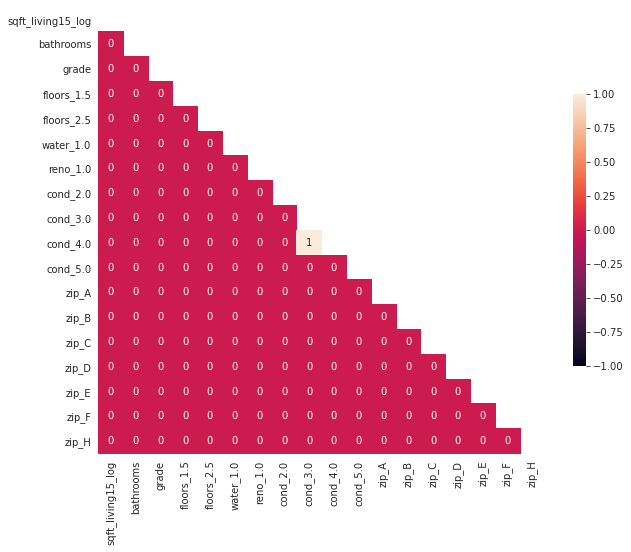

In [52]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/initial_model_multicollinarity_check')

Model has no multicollinarity except for cond_3.0 and cond_4.0.

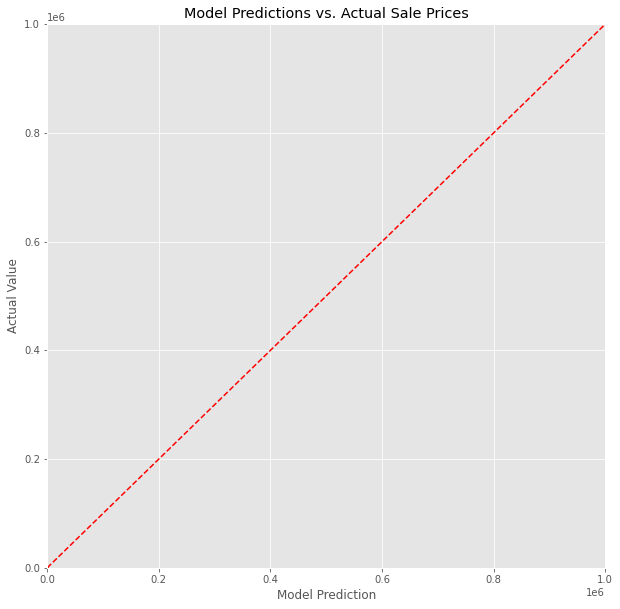

In [53]:
#plot y_hat
plt.figure(figsize = (10,10))
plt.scatter(yhat, y, s = 2, alpha = 0.3)
plt.plot([0,1000000], [0,1000000], color = 'red', ls = '--')
plt.xlim(0,1000000)
plt.ylim(0,1000000)
plt.title('Model Predictions vs. Actual Sale Prices')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/initial_model_test_scatterplot')

**Recheck for normality**

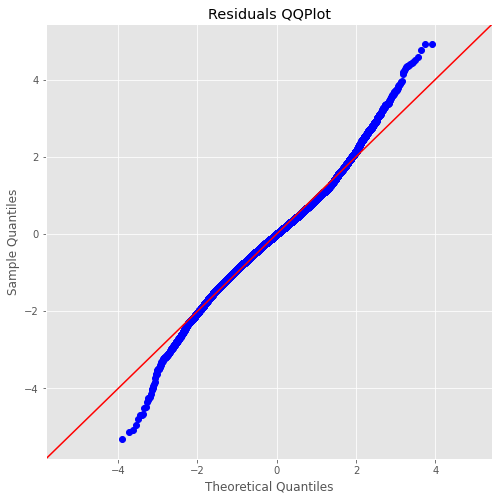

<Figure size 432x288 with 0 Axes>

In [54]:
#recheck for normality
fig = sm.graphics.qqplot(model.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(8, 8)
plt.title('Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/residuals_qqplot')

Initial model failed normality assumption.

**Recheck for homoscedasticity**

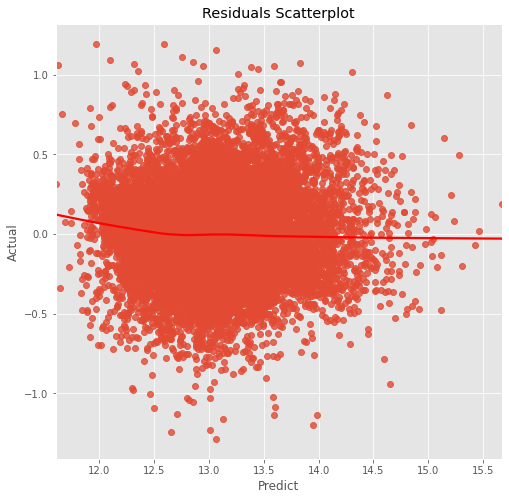

<Figure size 432x288 with 0 Axes>

In [55]:
#recheck for homoscedasticity
plt.figure(figsize = (8, 8))
sns.regplot(x = model.predict(), 
            y = model.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/homoscedasticity_regplot')

Initial model failed homoscedasticity assumption

**Recheck for overfitting: K-Fold Cross Validation**

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation. The downside of the train test split is that every time we do a split we obtain a slighlty different result. That's where doing Cross-Validation has a big advantage because with it we're doing a multiple split test and getting the average value from it.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

In [57]:
#cross-validation to check for overfitting (learn.co)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 50, scoring = mse)
cv_result

array([0.06720399, 0.04590376, 0.05461264, 0.06958673, 0.06026784,
       0.04407568, 0.04702811, 0.0571531 , 0.08123506, 0.03679778,
       0.06773999, 0.05230431, 0.06328236, 0.05266628, 0.0784099 ,
       0.05026647, 0.06207129, 0.08633425, 0.0582253 , 0.06722857,
       0.05392435, 0.08800825, 0.07408001, 0.06183037, 0.0641251 ,
       0.0707094 , 0.04702415, 0.06293071, 0.07331384, 0.09515993,
       0.06465873, 0.07077405, 0.06007357, 0.07898607, 0.05298687,
       0.06241119, 0.06212569, 0.05706965, 0.06425673, 0.05268781,
       0.06305669, 0.05699784, 0.06207787, 0.07459326, 0.08133367,
       0.07568334, 0.07563996, 0.06554275, 0.06185787, 0.06549331])

In [60]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

0.06403612828879096

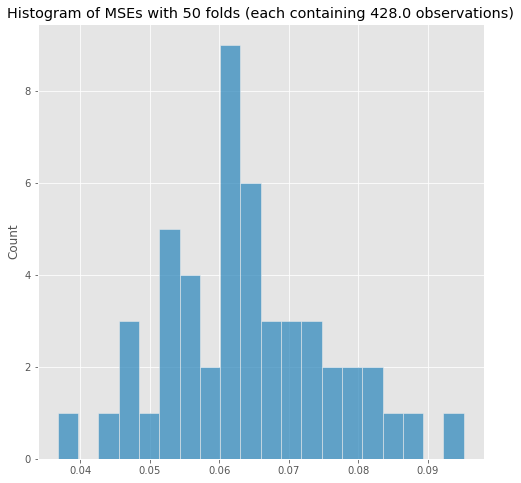

In [61]:
#visualize the cv_result

folds = 50
plt.figure(figsize = (8, 8))
sns.histplot(cv_result, bins = 20);
plt.title('Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_2) / folds, 0)));
plt.savefig('./Data & Figures/cv_result_histplot')

The above histogram suggests that even with 50 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

## Validate Initial Model

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [62]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [63]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

In [64]:
#fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression()

In [65]:
#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [66]:
#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [67]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.0639257684557631
0.061879686178680636


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

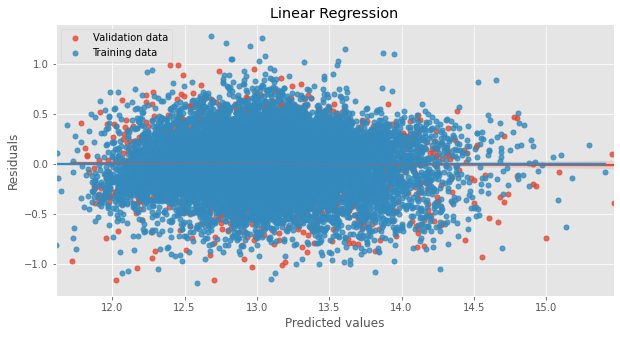

<Figure size 432x288 with 0 Axes>

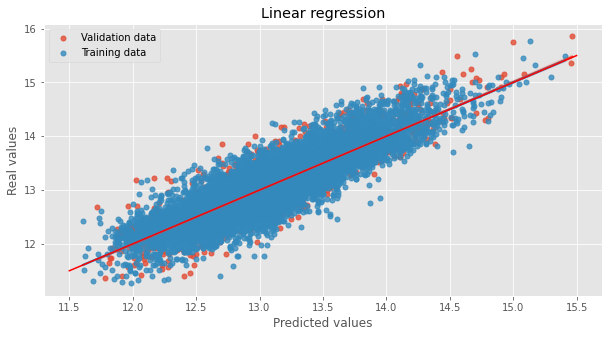

<Figure size 432x288 with 0 Axes>

In [68]:
#plot residuals: 
plt.figure(figsize = (10, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")


plt.title("Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/residuals_scatterplot')

#plot predictions
plt.figure(figsize = (10, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")

plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()
plt.savefig('./Data & Figures/predictions_scatterplot')

In [69]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 78%'

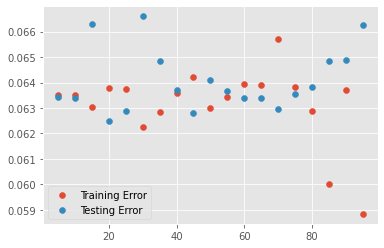

In [70]:
#evaluating the effect of train-test split size (learn.co)
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend();

### Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [71]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [72]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [73]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [74]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -4.557073180841782 
Train variance: 0.07598634088164147


In [75]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: -4.563072072575745 
Test variance: 0.07967255142014551


## MODEL REFINEMENT I: 
## Apply Polynomial Regression

Now it's time to determine the optimal degree of polynomial features for a model that is fit to this data. For each of second, third and fourth degrees: 

- Instantiate `PolynomialFeatures()` with the number of degrees 
- Fit and transform the `X_train` features 
- Instantiate and fit a linear regression model on the training data 
- Transform the test data into polynomial features 
- Use the model you built above to make predictions using the transformed test data 
- Evaluate model performance on the test data using `r2_score()` 
- In order to plot how well the model performs on the full dataset, transform `X` using `poly` 
- Use the same model (`reg_poly`) to make predictions using `X_poly` 

degree 2 0.7331658433362497
degree 3 -3.999385790290998e+17
degree 4 -172102.2659067655


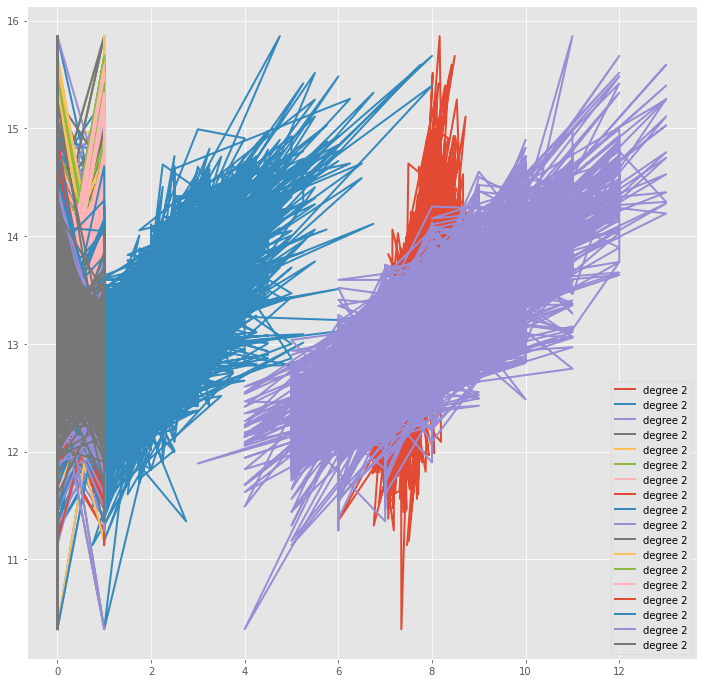

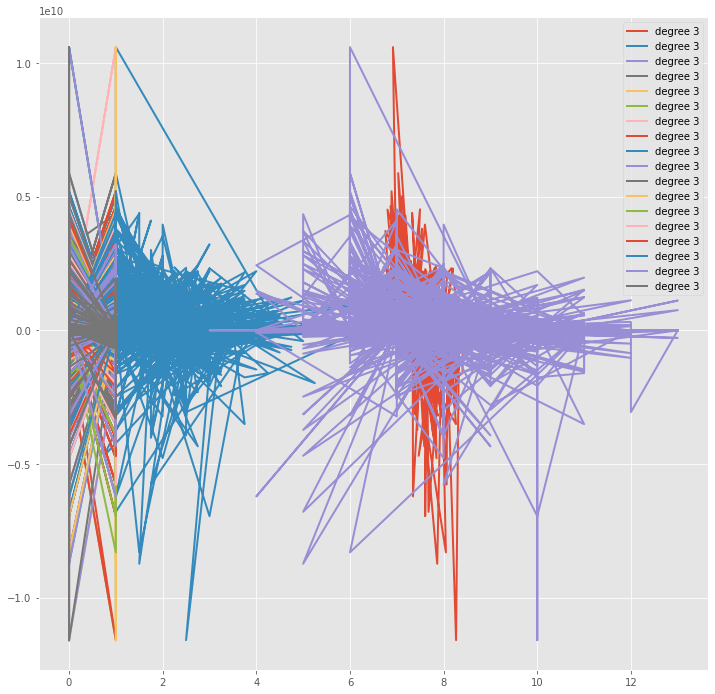

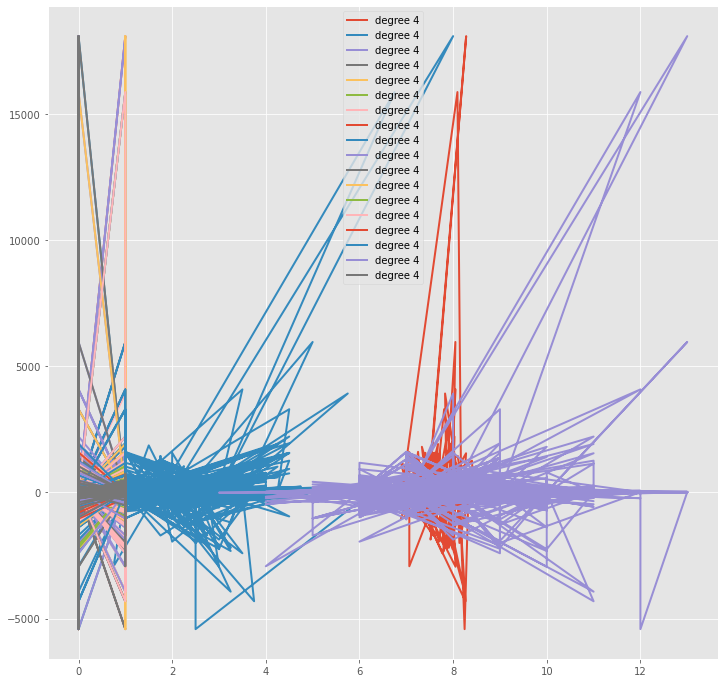

In [76]:
# We'll fit 3 different polynomial regression models from degree 2 to degree 4
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

for index, degree in enumerate([2, 3, 4]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.fit_transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data 
    y_poly = reg_poly.predict(X_poly)
    
    # Create plot of predicted values
    plt.figure(figsize = (12, 12))
    plt.plot(X, y_poly, linewidth=2, label='degree %d' % degree)
    plt.legend()

We see that the r2 is highest ( r2=0.767) and the root mean square error is lowest (rmse=0.255) for third order polynomial .So lets add a polynomil of degree 3 to out linear regression model.It will include interactions between diffrent features and make nour model more complex.

Not adding polynomials is prone to overfitting.

**Regularization: to reduce over fitting**

In [81]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
                                        
#fitting the above model on test set
test = make_pipeline(PolynomialFeatures(3,interaction_only=True), StandardScaler(), Lasso(0.0001))
test.fit(X_train, y_train)
test.predict(X_test)
rmse_te_Lasso=(np.sqrt(mean_squared_error(y_test, est.predict(X_test))))
r2_te_Lasso=(est.score(X_test,y_test))
print(rmse_te_Lasso,r2_te_Lasso)

NameError: name 'Lasso' is not defined

In [ ]:
#deloffing RMSE
rmse_test_delog=np.exp(rmse_te_Lasso)
print(rmse_test_delog)

The predicted values of home prices ( by this model)=Actual value of home prices +- 1.3%

The root mean square error for the training and the test sets are low and almost the same (rmse_test=0.279,rmse_training=0.266).So there is no over fitting or underfitting.Adding a polynomial of degree 3 and regularizing the model with Lasso regularization controlled for underfitting and over fitting.

In [ ]:
#Regression plot for residuals

test_pred=est.predict(X_test)
residuals_test=y_test-test_pred

plt.figure(figsize=(13,8))

sns.set(style="whitegrid")

sns.regplot(test_pred,y_test,scatter_kws={'color':'b','alpha':0.1},color='r')
sns.set(font_scale=1.3)
plt.title('Predicted vs Test')
plt.ylabel('Y_test')
plt.xlabel('Predicted Y')

In [ ]:

#Residual Plot

sns.set(style="whitegrid")


plt.figure(figsize=(13,8))

plt.scatter(test_pred ,residuals_test,alpha=0.2)
plt.xlabel('Predicted Y (Home prices)')
plt.ylabel('Residuals')
plt.title("Residual Plot")

In [ ]:

#Normal Q-Q plot

sns.set(style="whitegrid")


plt.figure(figsize=(13,8))
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [ ]:

sns.set(style="whitegrid")


plt.figure(figsize=(13,8))
sns.distplot(residuals_test, bins=50, kde=True)
plt.xlabel('Home Price')
plt.ylabel('Residuals')
plt.title("Distribution of Residuals")

## MODEL REFINEMENT II:
## INTERACTIONS

### See how interactions improve our baseline

Create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the  𝑅2 . We'll look at the 3 interactions which have the biggest effect on our  𝑅2 , so print out the top 3 combinations.

**Comment:** While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables. With that, it makes sense to briefly update the features once again and recheck for multicollinearity.

In [ ]:
regression = LinearRegression()

In [ ]:
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

In [ ]:
baseline = np.mean(cross_val_score(regression, X, y, scoring = 'r2', cv = crossvalidation))
baseline

In [ ]:
from itertools import combinations (learn.co)

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against SalePrice. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

In [ ]:
#fig, ax = plt.subplots(figsize=(13, 10))

col = 'zip_C'

is_in = preprocessed.loc[preprocessed['zip_C'] == 1, [col, 'price']]

linreg = LinearRegression()
linreg.fit(np.log(is_in[[col]]), np.log(is_in['price']))

preds = linreg.predict(np.log(is_in[[col]]))

plt.scatter(np.log(is_in[[col]]), np.log(is_in['price']), alpha=.3, label=None)

x = np.linspace(6, 12)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'In zip_C:   {linreg.coef_[0]:.2f}')

not_in = preprocessed.loc[preprocessed['zip_C'] == 0, [col, 'price']]

linreg = LinearRegression()
linreg.fit(np.log(not_in[[col]]), np.log(not_in['price']))

preds = linreg.predict(np.log(not_in[[col]]))

plt.scatter(np.log(not_in[[col]]), np.log(not_in['price']), alpha=.1, label=None)

x = np.linspace(6, 12)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'Outside of zip_C:   {linreg.coef_[0]:.2f}')

ax.legend()

In [ ]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['Neighborhood_Edwards*LotArea'] = final['Neighborhood_Edwards'] * final['LotArea']

final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))

final_model

In [ ]:
#r2has increased considerably! Let's have a look in statsmodels to see if this interactions are significant.
import statsmodels.api as sm

df_inter_sm = sm.add_constant(final)
model = sm.OLS(y, final)
results = model.fit()

results.summary()